In [1]:
# !jupyter nbconvert --to script pack_existing_segs.ipynb

In [2]:
import einops
import os

import matplotlib.pyplot as plt
import numpy as np
from tianshou.policy import PPOPolicy
import uuid
from tianshou.utils import WandbLogger, LazyLogger
from torch.utils.tensorboard import SummaryWriter
from gymnasium.wrappers import TimeLimit
from customs import CustomDQNPolicy, CustomOffpolicyTrainer
from dataset import *
from env import *
from networks.qnet import *
from networks.vit import ViTTrailEncoder
from networks.SimpleAC import Actor as SimpleActor, Critic as SimpleCritic
from tianshou.utils.net.common import ActorCritic
from tianshou.utils.net.discrete import Actor, Critic, IntrinsicCuriosityModule
from tianshou.trainer import OnpolicyTrainer
import torch
import tianshou as ts
from networks.mul_AC import Actor as MulActor, Critic as MulCritic
from networks.path_vit import BaseNetwork as MulBaseNetwork
import torch.nn.functional as F
import random
from networks.simmim import BaseNetwork as SimmimBase
from networks.beit import BaseNetwork as BeitBase

In [3]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [4]:
# if username is server use cuda
if os.environ['USER'] == 'server':
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    # device = 'cpu'
else:
    device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
# if __name__ == '__main__':
#     torch.multiprocessing.set_start_method('spawn')

In [5]:
def get_wandb(use_wandb):
    if use_wandb:
        wandb_logger = WandbLogger(
            train_interval=1,
            test_interval=1,
            update_interval=1,
            project="AttentionRL",
        )
        wandb_logger.load(SummaryWriter("./logs"))
    else:
        wandb_logger = LazyLogger()

    return wandb_logger

In [6]:
def get_train_fn(policy, eps_train, inital_phase):
    def train_fn(epoch, env_step):
        if eps_train:
            policy.set_eps(eps_train[epoch - 1])

        if epoch >= inital_phase:
            for param in policy.parameters():
                param.requires_grad = True

        if epoch >= 0 and epoch % 5 == 0 and use_wandb:
            torch.save(policy.state_dict(),
                       f'saved/policy_{wandb_logger.wandb_run.name if use_wandb else uuid.uuid4().hex}.pt')

        wandb_logger.write('train', trainer.env_step, {"epoch": epoch})

    return train_fn

In [7]:
def get_DQN_policy():
    config.update({
        "n_step": 1,
        "target_freq": 1200,
    })

    action_count = len(Actions)
    net = Q_network(action_count).to(device)
    optim = torch.optim.Adam(net.parameters(), lr=config['lr'])
    policy = CustomDQNPolicy(net, optim, discount_factor=config['gamma'], estimation_step=config['n_step'],
                             target_update_freq=config['target_freq'], polyak=None)
    # register_hooks(policy.model)
    return policy


def get_PPO_policy():
    config.update({
        "gae_lambda": 0.95,
        "max_grad_norm": 0.5,
        "vf_coef": 0.25,
        "ent_coef": .0001,
        "rew_norm": True,
        "eps_clip": 0.1,
        "value_clip": False,
        "dual_clip": 3,
        "norm_adv": True,
        "recompute_adv": 0,
    })

    # old base, built-in actor and critic
    # base_net = ViTTrailEncoder().to(device)
    # actor = Actor(base_net, len(Actions), device=device, softmax_output=False, hidden_sizes=[])
    # critic = Critic(base_net, device=device, hidden_sizes=[])    

    # old base, SimpleAC
    # base_net = ViTTrailEncoder().to(device)
    # actor = SimpleActor(base_net, len(Actions), device=device, softmax_output=False, hidden_sizes=[256])
    # critic = SimpleCritic(base_net, device=device, hidden_sizes=[512])

    # new base, built-in actor and critic
    # base_net = MulBaseNetwork(config['env_patch_size']).to(device)
    # actor = Actor(base_net, len(Actions), device=device, softmax_output=False)
    # critic = Critic(base_net, device=device)

    # new base, SimpleAC
    # base_net = MulBaseNetwork(config['env_patch_size']).to(device)
    # actor = SimpleActor(base_net, len(Actions), device=device, softmax_output=False, hidden_sizes=[256, 256])
    # critic = SimpleCritic(base_net, device=device, hidden_sizes=[512, 512])

    # new base, mulAC
    # base_net = MulBaseNetwork(config['env_patch_size']).to(device)
    # actor = MulActor(base_net.vit.config.hidden_size, base_net).to(device)
    # critic = MulCritic(base_net.vit.config.hidden_size, base_net).to(device)
    
    # simmim base, mulAC
    # base_net = SimmimBase(config['env_patch_size']).to(device)
    # actor = MulActor(base_net.vit.config.hidden_size, base_net).to(device)
    # critic = MulCritic(base_net.vit.config.hidden_size, base_net).to(device)

    # beit base, SimpleAC
    # base_net = BeitBase(config['env_patch_size']).to(device)
    # actor = SimpleActor(base_net, len(Actions), device=device, softmax_output=False, hidden_sizes=[256, 256])
    # critic = SimpleCritic(base_net, device=device, hidden_sizes=[512, 512])
    
    # beit base, mulAC
    base_net = BeitBase(config['env_patch_size']).to(device)
    actor = MulActor(base_net.vit.config.vocab_size, base_net).to(device)
    critic = MulCritic(base_net.vit.config.vocab_size, base_net).to(device)

    optim = torch.optim.Adam(
        ActorCritic(actor, critic).parameters(), lr=config['lr'], eps=1e-5
    )
    

    def dist(p):
        return torch.distributions.Categorical(logits=p)

    # policy = PPOPolicy(
    policy = TempPPO(
        actor=actor,
        critic=critic,
        optim=optim,
        dist_fn=dist,
        discount_factor=config['gamma'],
        gae_lambda=config['gae_lambda'],
        max_grad_norm=config['max_grad_norm'],
        vf_coef=config['vf_coef'],
        ent_coef=config['ent_coef'],
        reward_normalization=config['rew_norm'],
        action_scaling=False,
        eps_clip=config['eps_clip'],
        value_clip=config['value_clip'],
        dual_clip=config['dual_clip'],
        advantage_normalization=config['norm_adv'],
        recompute_advantage=config['recompute_adv'],
    ).to(device)
    return policy

In [8]:
from typing import Any, List, Dict
from tianshou.data import Batch
from tianshou.data import Batch, ReplayBuffer, to_torch_as

class TempPPO(PPOPolicy):
    def process_fn(
        self, batch: Batch, buffer: ReplayBuffer, indices: np.ndarray
    ) -> Batch:
        if self._recompute_adv:
            # buffer input `buffer` and `indices` to be used in `learn()`.
            self._buffer, self._indices = buffer, indices
        batch = self._compute_returns(batch, buffer, indices)
        batch.act = to_torch_as(batch.act, batch.v_s)
        with torch.no_grad():
            batch.logp_old = self(batch).dist.log_prob(batch.act)
        return batch    
    
    def learn(  # type: ignore
            self, batch: Batch, batch_size: int, repeat: int, **kwargs: Any
    ) -> Dict[str, List[float]]:
        losses, clip_losses, vf_losses, ent_losses = [], [], [], []
        for step in range(repeat):
            if self._recompute_adv and step > 0:
                batch = self._compute_returns(batch, self._buffer, self._indices)
            for minibatch in batch.split(batch_size, merge_last=True):
                # calculate loss for actor
                dist = self(minibatch).dist
                if self._norm_adv:
                    mean, std = minibatch.adv.mean(), minibatch.adv.std()
                    minibatch.adv = (minibatch.adv -
                                     mean) / (std + self._eps)  # per-batch norm
                ratio = (dist.log_prob(minibatch.act) -
                         minibatch.logp_old).exp().float()
                ratio = ratio.reshape(ratio.size(0), -1).transpose(0, 1)
                print(ratio)
                surr1 = ratio * minibatch.adv
                surr2 = ratio.clamp(
                    1.0 - self._eps_clip, 1.0 + self._eps_clip
                ) * minibatch.adv
                if self._dual_clip:
                    clip1 = torch.min(surr1, surr2)
                    clip2 = torch.max(clip1, self._dual_clip * minibatch.adv)
                    clip_loss = -torch.where(minibatch.adv < 0, clip2, clip1).mean()
                else:
                    clip_loss = -torch.min(surr1, surr2).mean()
                # calculate loss for critic
                value = self.critic(minibatch.obs).flatten()
                if self._value_clip:
                    v_clip = minibatch.v_s + \
                             (value - minibatch.v_s).clamp(-self._eps_clip, self._eps_clip)
                    vf1 = (minibatch.returns - value).pow(2)
                    vf2 = (minibatch.returns - v_clip).pow(2)
                    vf_loss = torch.max(vf1, vf2).mean()
                else:
                    vf_loss = (minibatch.returns - value).pow(2).mean()
                # calculate regularization and overall loss
                ent_loss = dist.entropy().mean()
                loss = clip_loss + self._weight_vf * vf_loss \
                       - self._weight_ent * ent_loss
                self.optim.zero_grad()
                loss.backward()
                if self._grad_norm:  # clip large gradient
                    nn.utils.clip_grad_norm_(
                        self._actor_critic.parameters(), max_norm=self._grad_norm
                    )
                self.optim.step()
                clip_losses.append(clip_loss.item())
                vf_losses.append(vf_loss.item())
                ent_losses.append(ent_loss.item())
                losses.append(loss.item())

        return {
            "loss": losses,
            "loss/clip": clip_losses,
            "loss/vf": vf_losses,
            "loss/ent": ent_losses,
        }

In [9]:
def get_offpolicy_trainer(policy):
    replay_buffer = ts.data.VectorReplayBuffer(config['buffer_size'], len(config['train_envs']))
    train_collector = ts.data.Collector(policy, config['train_envs'], replay_buffer, exploration_noise=True)

    config.update({
        "eps_start": 0.9,
        "eps_end": 0.05,
        'update_per_step': 1 / config['step_per_collect'] * 4,
        "eps_train": np.linspace(0.9, 0.05, 2000),
        "eps_test": 0,
    })
    trainer = CustomOffpolicyTrainer(
        policy=policy,
        train_collector=train_collector,
        test_collector=None,
        episode_per_test=1,  #dummy
        max_epoch=config['epoch'],
        step_per_epoch=config['step_per_epoch'],
        step_per_collect=config['step_per_collect'],
        batch_size=config['batch_size'],
        update_per_step=config['update_per_step'],
        train_fn=get_train_fn(policy, config['eps_train'], config['initial_phase']),
        test_fn=lambda epoch, env_step: policy.set_eps(config['eps_test']),
        logger=wandb_logger,
    )
    return trainer


def get_onpolicy_trainer(policy):
    replay_buffer = ts.data.VectorReplayBuffer(
        config['buffer_size'],
        len(config['train_envs']),
    )
    train_collector = ts.data.Collector(policy, config['train_envs'], replay_buffer, exploration_noise=True)
    test_collector = ts.data.Collector(policy, config['test_envs'])

    config.update({
        'repeat_per_collect': 5,
        'episode_per_test': 5,
    })

    trainer = OnpolicyTrainer(
        policy=policy,
        train_collector=train_collector,
        test_collector=test_collector,
        max_epoch=config['epoch'],
        step_per_epoch=config['step_per_epoch'],
        repeat_per_collect=config['repeat_per_collect'],
        batch_size=config['batch_size'],
        step_per_collect=config['step_per_collect'],
        episode_per_test=config['episode_per_test'],
        train_fn=get_train_fn(policy, None, config['initial_phase']),
        logger=wandb_logger,
    )

    return trainer

In [10]:
if __name__ == "__main__":  ########Policy Initialization########
    config = {
        "lr": 8e-5,
        "epoch": 2000,
        "batch_size": 256,
        "initial_phase": 2000,
        "gamma": 0.98,
        "buffer_size": 1000,
        "env_step_limit": 100,
        "env_step_limit_test": 100,
        "env_step_mem": 100,
        "env_patch_size": (32, 32),
        'num_train_envs': 1,
        'step_per_collect': 100 * 8,
        "step_per_epoch": 20 * 64 * 4,
    }

    # dataset = COCODataset(train=True, indices=[12], no_seg=True, fix_resize=(224-3*32, 224-3*32))
    dataset = COCODataset(train=True, length=5000, no_seg=True, fix_resize=(224-3*32, 224-3*32))

    if config['num_train_envs'] > 1:
        train_envs = ts.env.SubprocVectorEnv([lambda: TimeLimit(
            Environment(dataset, config['env_patch_size'], max_len=config['env_step_mem']), config['env_step_limit'])
                                              for _ in range(config['num_train_envs'])])
    else:
        train_envs = ts.env.DummyVectorEnv(
            [lambda: TimeLimit(Environment(dataset, config['env_patch_size'], max_len=config['env_step_mem']),
                               config['env_step_limit']) for _ in range(1)])
    config['train_envs'] = train_envs
    config['test_envs'] = ts.env.DummyVectorEnv(
        [lambda: TimeLimit(Environment(dataset, config['env_patch_size'], max_len=config['env_step_mem']),
                           config['env_step_limit_test']) for _ in range(1)])

    # policy = get_DQN_policy()
    policy = get_PPO_policy()

In [11]:
# policy = torch.compile(policy)
torch.set_float32_matmul_precision('medium')

In [12]:
# print(policy.load_state_dict(torch.load("./saved/policy_vital-dream-126.pt")))

<All keys matched successfully>


In [ ]:
if __name__ == "__main__":  ########Training########
    use_wandb = True
    torch.set_printoptions(precision=4, sci_mode=False)
    wandb_logger = get_wandb(use_wandb)
    
    # trainer = get_offpolicy_trainer(policy)
    trainer = get_onpolicy_trainer(policy)
    
    if use_wandb:
        wandb_logger.wandb_run.config.update(config)
    
    with torch.autograd.set_detect_anomaly(True):
        trainer.run()

In [ ]:
# runckpt
    # if __name__ == "__main__":
#     env = TimeLimit(Environment(dataset, (32, 32)), 200)
#     ut.show_masks_on_image(einops.rearrange(env.current_image, 'c h w -> h w c'), env.current_seg.cpu().numpy())
#     plt.show()

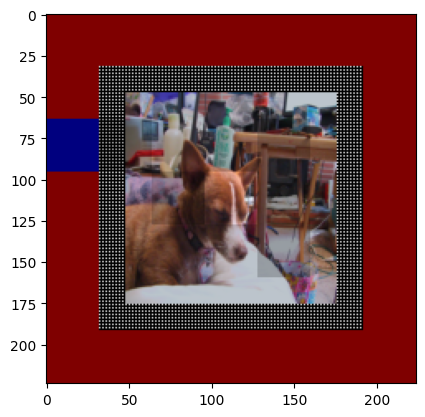

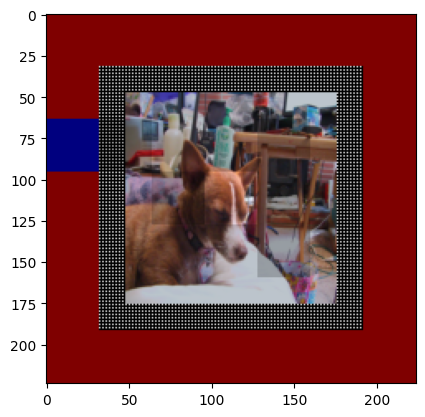

In [13]:
if __name__ == "__main__":
    policy.eval()
    # policy.set_eps(config['eps_test'])
    dataset = COCODataset(train=True, indices=[40009], no_seg=True, fix_resize=(224-3*32, 224-3*32))
    env = TimeLimit(Environment(dataset, config['env_patch_size'], max_len=config['env_step_mem']),
                    config['env_step_limit_test'])
    collector = ts.data.Collector(policy, env, exploration_noise=False)
    collector.collect(n_episode=1, render=1 / 5)
    # collector.collect(n_step=1, render=1 / 5)